## Imports and setup of SH API

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import box
from datetime import datetime
import rasterio as rs
from rasterio.plot import show
from osgeo import gdal
import tifffile as tiff
import os
from PIL import Image
from sklearn import metrics 

# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.geom import mask_dataset_by_geometry
import rioxarray
import xarray as xr

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 20,8

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [4]:
get_data_store_params_schema('sentinelhub')

In [5]:
store = new_data_store('sentinelhub', num_retries=400)

In [6]:
list(store.get_data_ids())

['S2L1C', 'S1GRD', 'S2L2A', 'DEM']

In [7]:
store.describe_data('S2L2A')

---

## Importing and exploring the landslide inventory

In [8]:
landslide_inventory = pd.read_csv('inventory.csv')

In [11]:
gdf = gpd.GeoDataFrame(
    landslide_inventory, geometry=gpd.points_from_xy(landslide_inventory.longitude, landslide_inventory.latitude), crs="EPSG:4326"
)

In [14]:
gdf.to_file('inventory.shp')  

<Axes: >

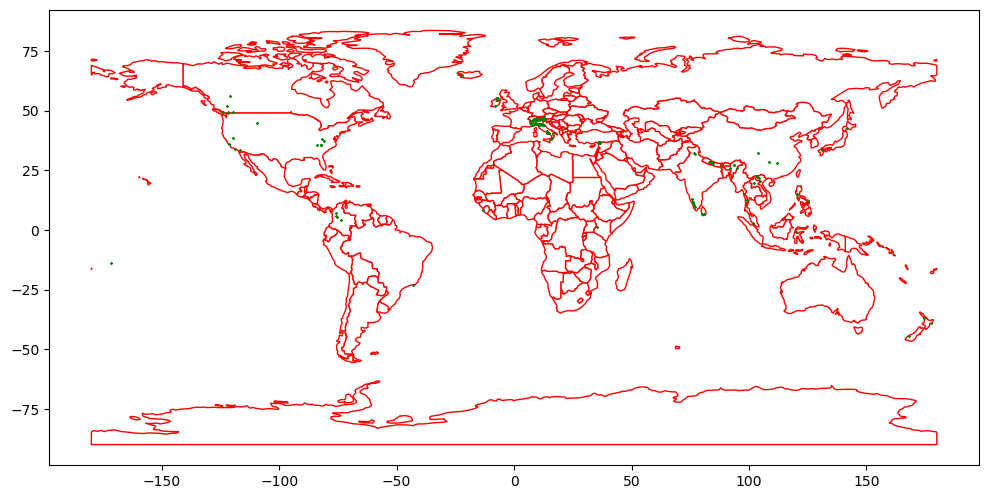

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='red', figsize = (12,12))
gdf.plot(ax = base, marker='*', color='green', markersize=1)

### API EXTRACTION AND VISUALIZATION OF ONE OF THE EVENTS FROM THE .CSV FILE

In [10]:
# --- import the landslide inventory as pandas DataFrame ---
landslide_inventory = pd.read_csv('inventory.csv')

i = 36 # choosing the event for which to retrieve the images
x = 0.01 # choosing the buffer around the location of the event (0.01 ~= 1 km)

# --- defining the bounding box ---
bbox = [landslide_inventory.iloc[i].longitude - x, landslide_inventory.iloc[i].latitude - x,
        landslide_inventory.iloc[i].longitude + x, landslide_inventory.iloc[i].latitude + x]

# --- defining the time ranges ---
time_range_pre = (landslide_inventory.iloc[i]["pre1"], landslide_inventory.iloc[i]["pre1"])
time_range_post = (landslide_inventory.iloc[i]["post1"], landslide_inventory.iloc[i]["post1"])

dataset_pre = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00009,  #~= 10m
                          time_range=time_range_pre, 
                          time_period='1D',
                          tile_size= [1024, 1024])

dataset_post = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00009, #~= 10m
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])


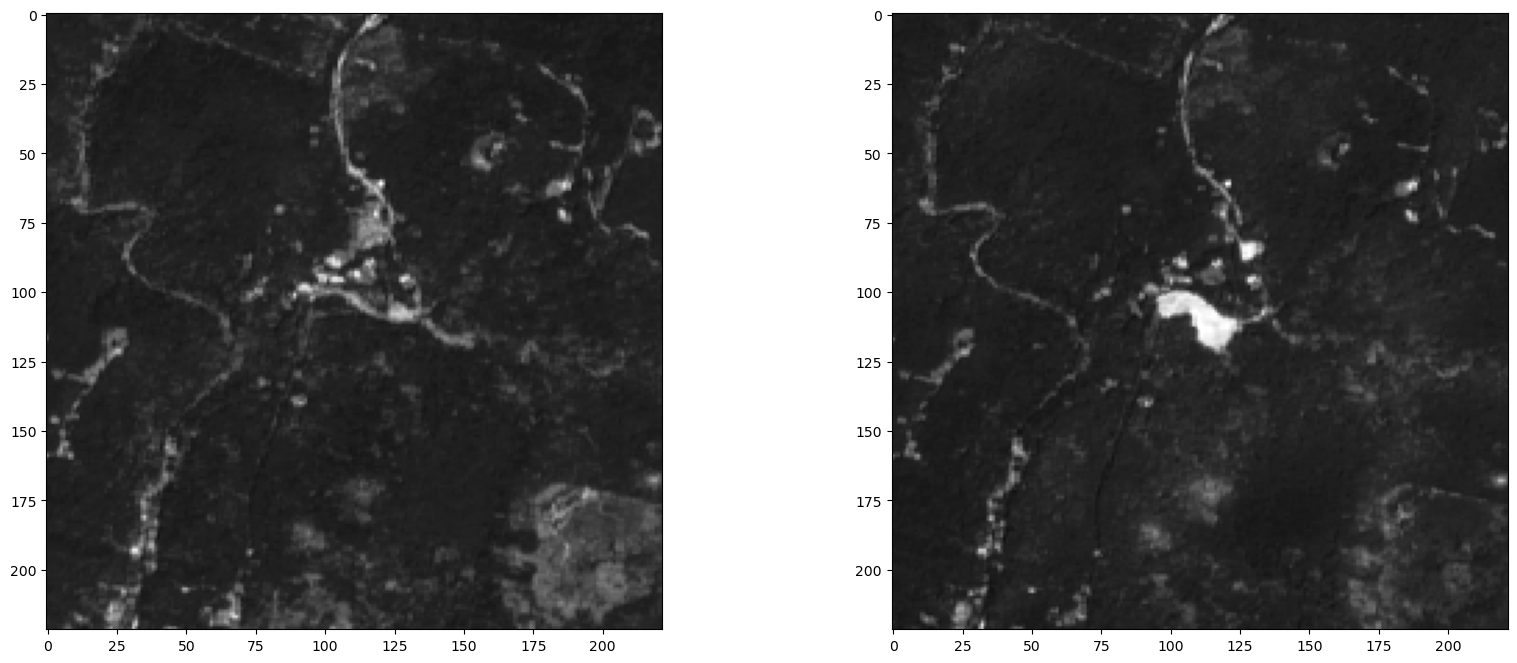

In [11]:
f, axarr = plt.subplots(1,2)
pre = dataset_pre.B04[0]
post = dataset_post.B04[0]

axarr[0].imshow(pre, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(post, vmin=0, vmax=0.2, cmap='Greys_r')

---

## Retrieving the images through SH API, DFs creation, cloud masking, saving to NetCDF

In [11]:
landslide_list_3 = []
landslide_list_2 = []
ident = 0
x = 0.01
for index, row in landslide_inventory.iterrows():
    event_date = row.event_date
    bbox = [row.longitude - x, row.latitude - x, row.longitude + x, row.latitude + x]
    poly = box(bbox[0], bbox[1], bbox[2], bbox[3])
    time_range_pre1 = (row.pre1, row.pre1)
    time_range_pre2 = (row.pre2, row.pre2)
    time_range_post = (row.post1, row.post1)
    
    dataset_pre = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_pre1, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    """
    dataset_pre2 = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_pre2, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    """
    dataset_post = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    """
    landslide_list_3.append(
        {
            #'event_date':event_date,
            #'bbox':poly,
            'pre1':dataset_pre1,
            'pre2':dataset_pre2, 
            'post':dataset_post
        }
    )
    
    landslide_list_2.append(
        {
            'T1':dataset_pre1,
            'T2':dataset_pre2,
            'fid':ident
        }
    )
    """
    landslide_list_2.append(
        {
            'T1':dataset_pre,
            'T2':dataset_post, 
            #'fid':ident
        }
    )
    ident = ident + 1

In [12]:
#landslide_df_3 = pd.DataFrame(landslide_list_3)
landslide_df = pd.DataFrame(landslide_list_2)

In [67]:
landslide_df

,T1,T2
0,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
1,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
2,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
3,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
4,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
...,...,...
169,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
170,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
171,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"
172,"[B02, B03, B04, B08, CLM]","[B02, B03, B04, B08, CLM]"


In [10]:
GT_landslide_list = []
event_no = [2,36,41,42,61,75,108,121,125,128,135,140,155,158,164,171,173]

In [16]:
GT_landslide_list = []
event_no = [2,36,41,42,61,75,108,121,125,128,135,140,155,158,164,171,173]
x = 0.01
for index in event_no:
    event = landslide_inventory.iloc[index]
    event_date = event.event_date
    bbox = [event.longitude - x, event.latitude - x, event.longitude + x, event.latitude + x]
    poly = box(bbox[0], bbox[1], bbox[2], bbox[3])
    time_range_pre2 = (event.pre2, event.pre2)
    time_range_post = (event.post1, event.post1)
    
    dataset_pre2 = store.open_data('S2L2A', 
                          variable_names=['B10'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_pre2, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    
    dataset_post = store.open_data('S2L2A', 
                          variable_names=['B10'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    
    GT_landslide_list.append(
        {
            'T1':dataset_pre2,
            'T2':dataset_post,
            'id':index
        }
    )
    
GT_landslide_df = pd.DataFrame(GT_landslide_list)
GT_landslide_df

,T1,T2,id
0,[B10],[B10],2
1,[B10],[B10],36
2,[B10],[B10],41
3,[B10],[B10],42
4,[B10],[B10],61
5,[B10],[B10],75
6,[B10],[B10],108
7,[B10],[B10],121
8,[B10],[B10],125
9,[B10],[B10],128


### Creating a cloud mask in both DFs for the events

In [21]:
for index, row in landslide_df_3.iterrows():
    mask = row.pre1.CLM[0] + row.pre2.CLM[0] + row.post.CLM[0]
    row.pre1.CLM[0] = mask
    row.pre2.CLM[0] = mask
    row.post.CLM[0] = mask
    
    landslide_df_2.iloc[2*index].T1.CLM[0] = mask
    landslide_df_2.iloc[2*index].T2.CLM[0] = mask
    landslide_df_2.iloc[2*index+1].T1.CLM[0] = mask
    landslide_df_2.iloc[2*index+1].T2.CLM[0] = mask

In [27]:
B02 = landslide_df_3.loc[42].pre1#.B02[0].to_numpy()
B02.map(cloud_mask())
#mask = landslide_df_3.loc[42].pre1.CLM[0].to_numpy()

<xarray.Dataset>
Dimensions:    (time: 1, lat: 2048, lon: 2048, bnds: 2)
Coordinates:
  * lat        (lat) float64 9.778 9.778 9.778 9.778 ... 9.758 9.758 9.758 9.758
  * lon        (lon) float64 77.1 77.1 77.1 77.1 ... 77.12 77.12 77.12 77.12
  * time       (time) datetime64[ns] 2018-04-04T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-02-06T21:02:00.082609
    time_coverage_start:       2018-04-04T00:00:00+00:00
    time_coverage_end:         2018-04-05T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        77.09745799999999
    geospatial_lat_min:        9.757839
    geospatial_lon_max:        77.117938
    geospatial_lat_max:        9.778319
    processing_level:          L2A

In [60]:
x = ma.array(B02, mask=mask, fill_value = 0)
x.filled([None])

array([[0.0341, 0.0341, 0.0341, ..., 0.0699, 0.078 , 0.078 ],
       [0.0341, 0.0341, 0.0341, ..., 0.0699, 0.078 , 0.078 ],
       [0.0341, 0.0341, 0.0341, ..., 0.0799, 0.0848, 0.0848],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]],
      dtype=float32)

In [23]:
masks = []
for index, row in landslide_df_3.iterrows():
    mask = row.pre1.CLM[0].to_numpy()
    print(index)
    masks.append(mask)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


In [33]:
ile = []
for i in range(len(masks)):
    if len(np.unique(masks[i])) == 2:
        ile.append(i)

In [36]:
print(ile, len(ile))

[1, 6, 11, 18, 22, 26, 30, 38, 39, 42, 66, 67, 76, 77, 79, 85, 90, 91, 92, 93, 94, 105, 106, 110, 112, 117, 118, 132, 133, 139, 146, 149, 151, 152, 154] 35


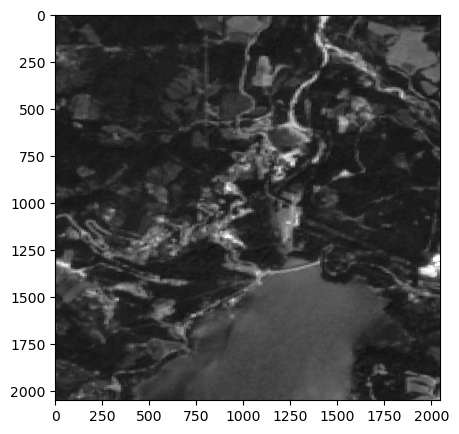

In [57]:
mask = B02 = landslide_df_3.loc[76].post.B02[0]
f, axarr = plt.subplots(1,1)
axarr.imshow(mask, vmin=0, vmax=0.2, cmap='Greys_r')

### Saving the xr.Datasets to NetCDF [do not run]

In [ ]:
for index, row in landslide_df.iterrows():
    pre1 = xr.Dataset(row.pre1.isel(time=0))
    pre2 = xr.Dataset(row.pre2.isel(time=0))
    post = xr.Dataset(row.post.isel(time=0))
    pre1_dir = "NetCDF/pre1_" + str(index) + ".nc"
    pre2_dir = "NetCDF/pre2_" + str(index) + ".nc"
    post_dir = "NetCDF/post_" + str(index) + ".nc"
    pre1.to_netcdf(pre1_dir)
    pre2.to_netcdf(pre2_dir)
    post.to_netcdf(post_dir)

---

## Exploring the two created DF

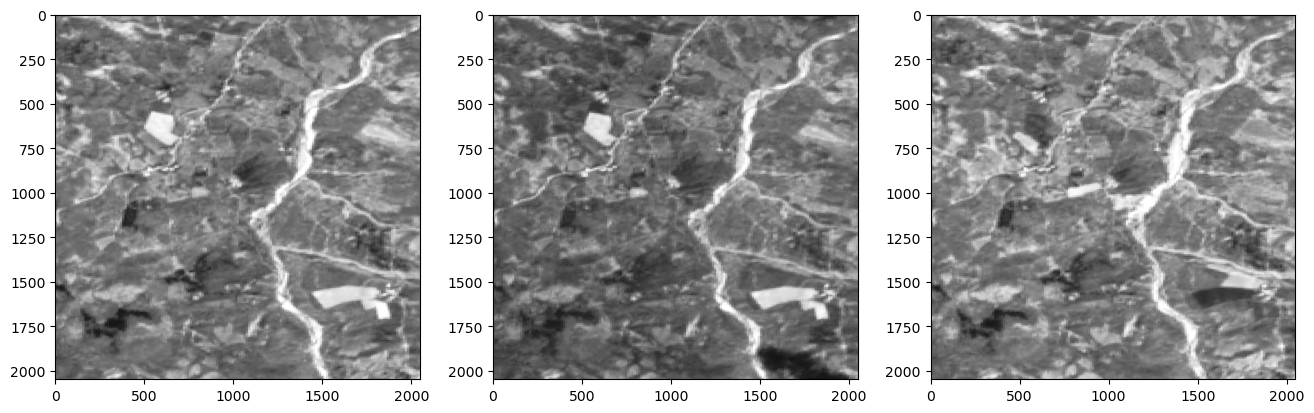

In [15]:
i = 108
f, axarr = plt.subplots(1,3)
img1 = landslide_df_3.iloc[i].pre1.B04[0]
img2 = landslide_df_3.iloc[i].pre2.B04[0]
img3 = landslide_df_3.iloc[i].post.B04[0]
axarr[0].imshow(img1, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(img2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2].imshow(img3, vmin=0, vmax=0.2, cmap='Greys_r')

### Pairs from which change maps will be created

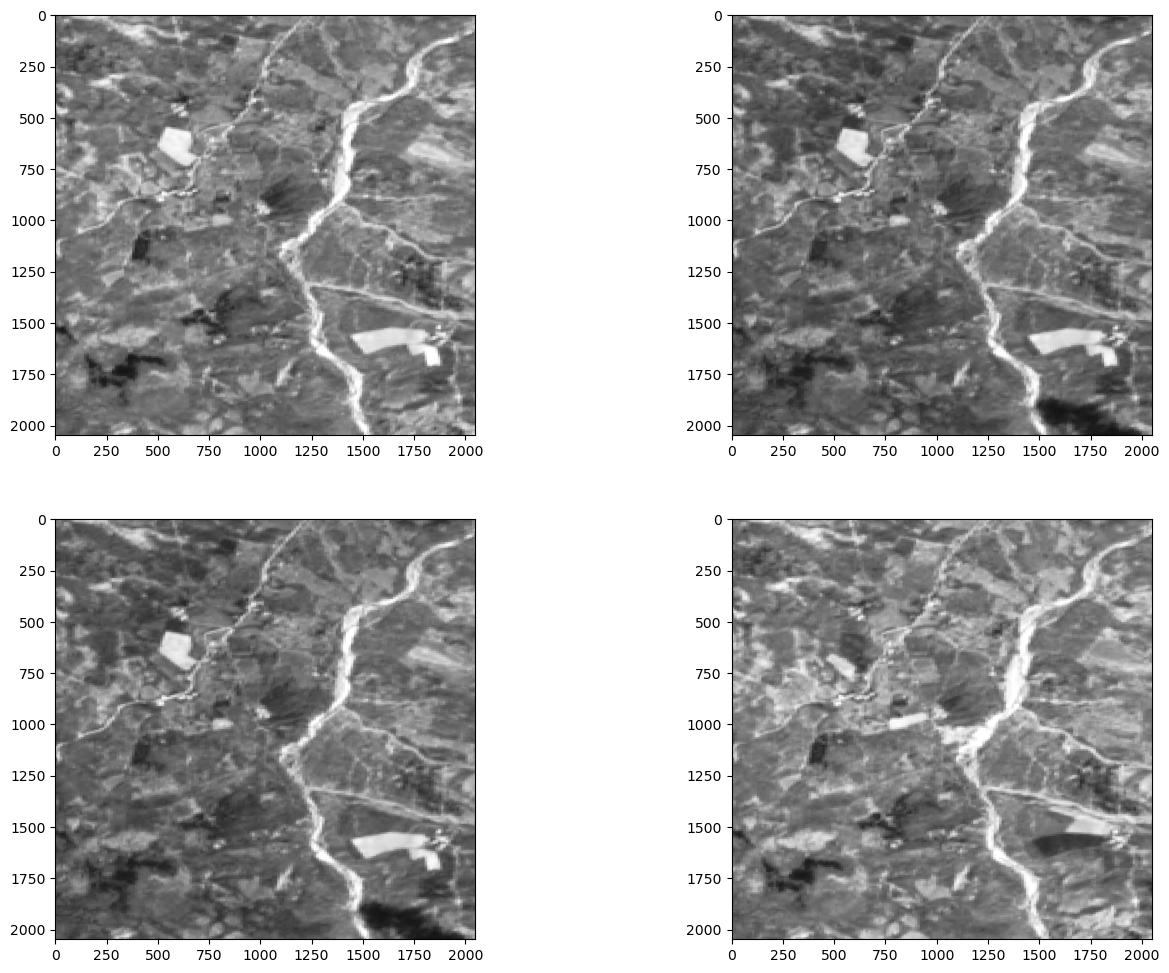

In [16]:
f, axarr = plt.subplots(2,2)
img1 = landslide_df_2.iloc[2*i].T1.B04[0]
img2 = landslide_df_2.iloc[2*i].T2.B04[0]
img3 = landslide_df_2.iloc[2*i+1].T1.B04[0]
img4 = landslide_df_2.iloc[2*i+1].T2.B04[0]
axarr[0][0].imshow(img1, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(img2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(img3, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(img4, vmin=0, vmax=0.2, cmap='Greys_r')

---

## Change map calculation using differential imaging and threshold analysis

(array([  29177., 3963341.,  166527.]),
 array([-0.1 , -0.05,  0.  ,  0.05]),
 <BarContainer object of 3 artists>)

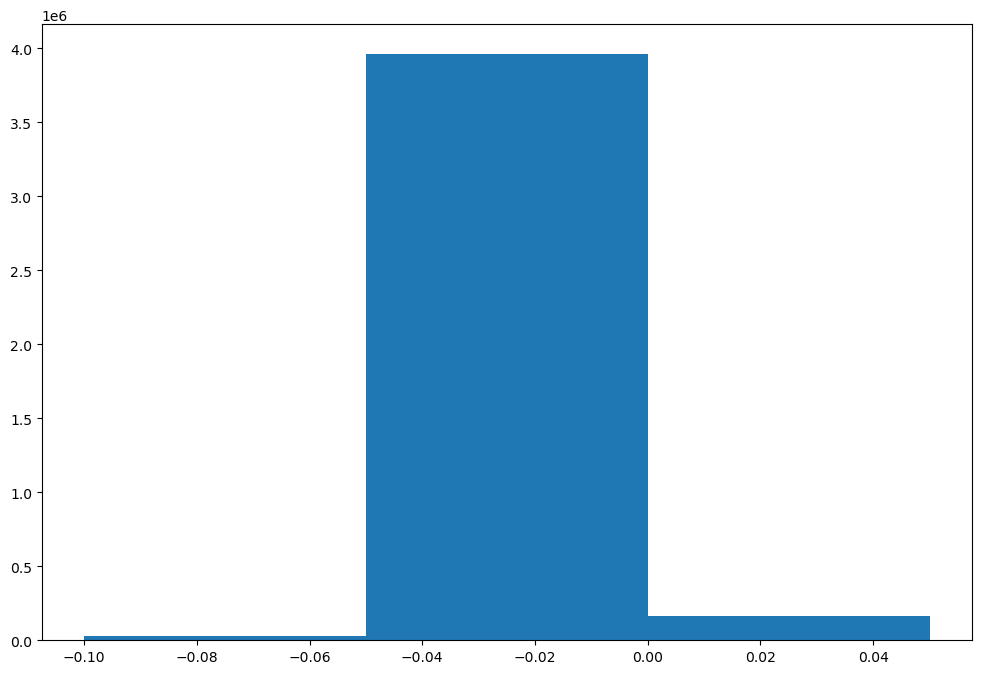

In [21]:
i = 2
band = "B05"
T1 = GT_landslide_df.iloc[i].T1
T2 = GT_landslide_df.iloc[i].T2
pre_event_image = T1[band][0]
post_event_image = T2[band][0]
change_map = post_event_image - pre_event_image

plt.hist(change_map.values.flatten(), bins = np.arange(-0.1, 0.1, 0.05))

[]

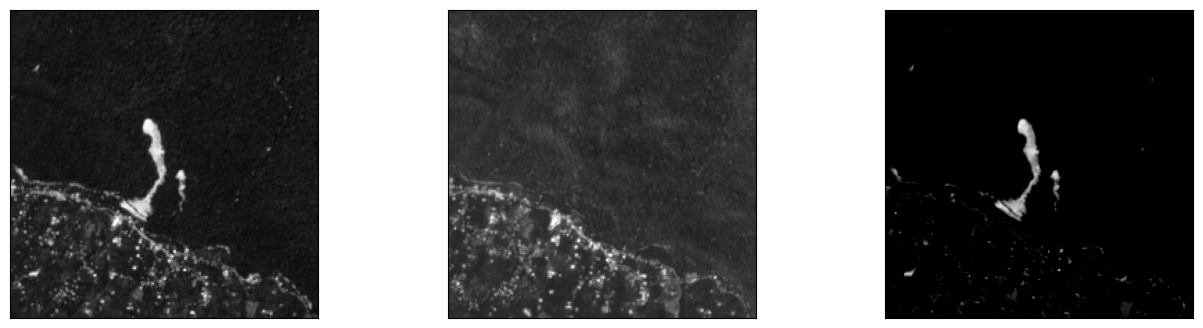

In [51]:
T1 = GT_landslide_df.iloc[2].T1
T2 = GT_landslide_df.iloc[2].T2

pre_event_image = T1["B04"][0]
post_event_image = T2["B04"][0]

change_map = post_event_image - pre_event_image

threshold = 0.05 # Example threshold value
binary_change_map_l = (change_map > threshold).astype(int)

f, axarr =  plt.subplots(1,3)
axarr[0].imshow(post_event_image, vmin=0, vmax=0.2, cmap='Greys_r')
#axarr[0].set_title("Pre-event image (B04)")
axarr[0].xaxis.set_tick_params(labelbottom=False)
axarr[0].yaxis.set_tick_params(labelleft=False)
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(pre_event_image, vmin=0, vmax=0.2, cmap='Greys_r')
#axarr[1].set_title("Post-event image (B04)")
axarr[1].xaxis.set_tick_params(labelbottom=False)
axarr[1].yaxis.set_tick_params(labelleft=False)
axarr[1].set_xticks([])
axarr[1].set_yticks([])

axarr[2].imshow(change_map, vmin=0, vmax=0.2, cmap='Greys_r')
#axarr[1].set_title("Post-event image (B04)")
axarr[2].xaxis.set_tick_params(labelbottom=False)
axarr[2].yaxis.set_tick_params(labelleft=False)
axarr[2].set_xticks([])
axarr[2].set_yticks([])

[]

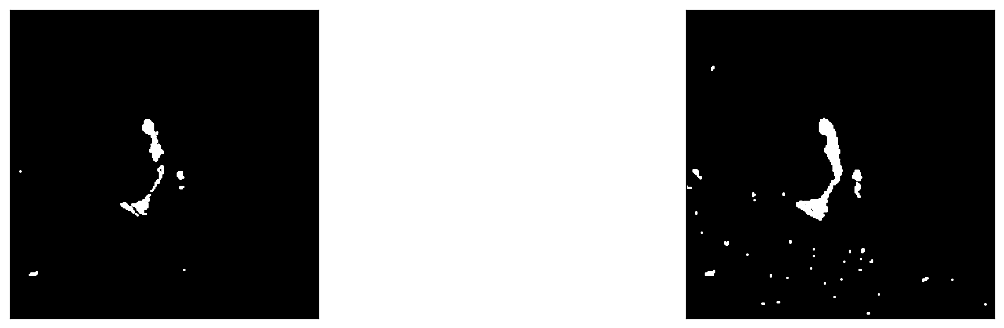

In [52]:
threshold = 0.05 # Example threshold value
binary_change_map_5 = (change_map > 0.05).astype(int)
binary_change_map_1 = (change_map > 0.1).astype(int)

f, axarr =  plt.subplots(1,2)
axarr[0].imshow(binary_change_map_1, vmin=0, vmax=0.2, cmap='Greys_r')
#axarr[0].set_title("Pre-event image (B04)")
axarr[0].xaxis.set_tick_params(labelbottom=False)
axarr[0].yaxis.set_tick_params(labelleft=False)
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(binary_change_map_5, vmin=0, vmax=0.2, cmap='Greys_r')
#axarr[1].set_title("Post-event image (B04)")
axarr[1].xaxis.set_tick_params(labelbottom=False)
axarr[1].yaxis.set_tick_params(labelleft=False)
axarr[1].set_xticks([])
axarr[1].set_yticks([])

In [28]:
T1 = GT_landslide_df.iloc[0].T1
T2 = GT_landslide_df.iloc[0].T2
pre_event_image = T1.B10[0]
post_event_image = T2.B10[0]
change_map = post_event_image - pre_event_image
threshold = 0.05 
binary_change_map_l = (change_map > threshold).astype(int)
path_l = "DATA/thresholds_005/threshold_B10/" + str(GT_landslide_df.iloc[0].id) + ".png"
#image = Image.fromarray((np.asarray(binary_change_map_l)).astype(np.uint8))
#image.save(path_l)
#image
binary_change_map_l

<xarray.DataArray 'B10' (lat: 2048, lon: 2048)>
dask.array<astype, shape=(2048, 2048), dtype=int64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.87 35.87 35.87 35.87 ... 35.85 35.85 35.85 35.85
  * lon      (lon) float64 -121.4 -121.4 -121.4 -121.4 ... -121.4 -121.4 -121.4

Failed to fetch data from Sentinel Hub after 142.64757347106934 seconds and 400 retries
HTTP status code was 400
Failed to fetch data from Sentinel Hub after 142.58725428581238 seconds and 400 retries
HTTP status code was 400


In [17]:
for i in range(len(GT_landslide_df)):
    T1 = GT_landslide_df.iloc[i].T1
    T2 = GT_landslide_df.iloc[i].T2

    pre_event_image = T1.B10[0]
    post_event_image = T2.B10[0]

    change_map = post_event_image - pre_event_image

    threshold = 0.05 
    binary_change_map_l = (change_map > threshold).astype(int)

    path_l = "DATA/thresholds_005/threshold_B10/" + str(GT_landslide_df.iloc[i].id) + ".png"
    image = Image.fromarray((np.asarray(binary_change_map_l)).astype(np.uint8))
    image.save(path_l)

Failed to fetch data from Sentinel Hub after 91.40005898475647 seconds and 400 retries
HTTP status code was 400


SentinelHubError: 400 Client Error: Bad Request for url: https://services.sentinel-hub.com/api/v1/process

Failed to fetch data from Sentinel Hub after 91.7186918258667 seconds and 400 retries
HTTP status code was 400


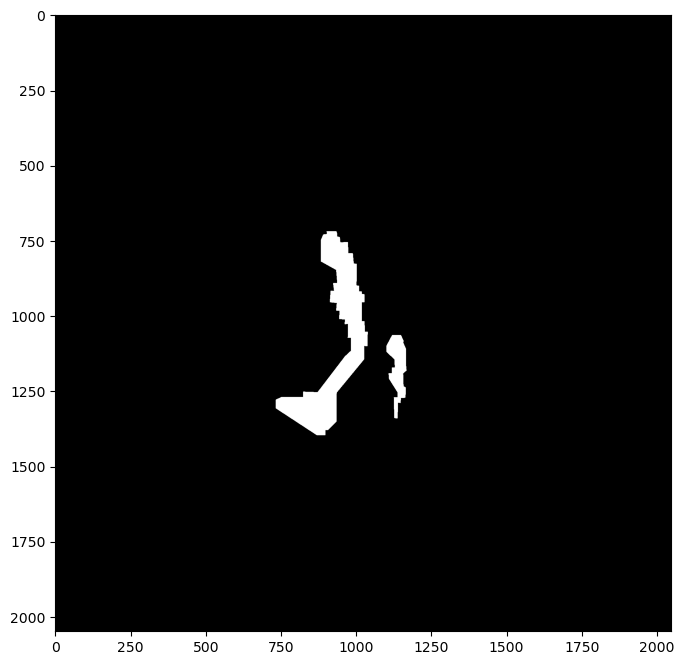

In [25]:
im = Image.open("DATA/thresholds_005/threshold_B10/173.png")
plt.imshow(im, cmap='Greys_r')

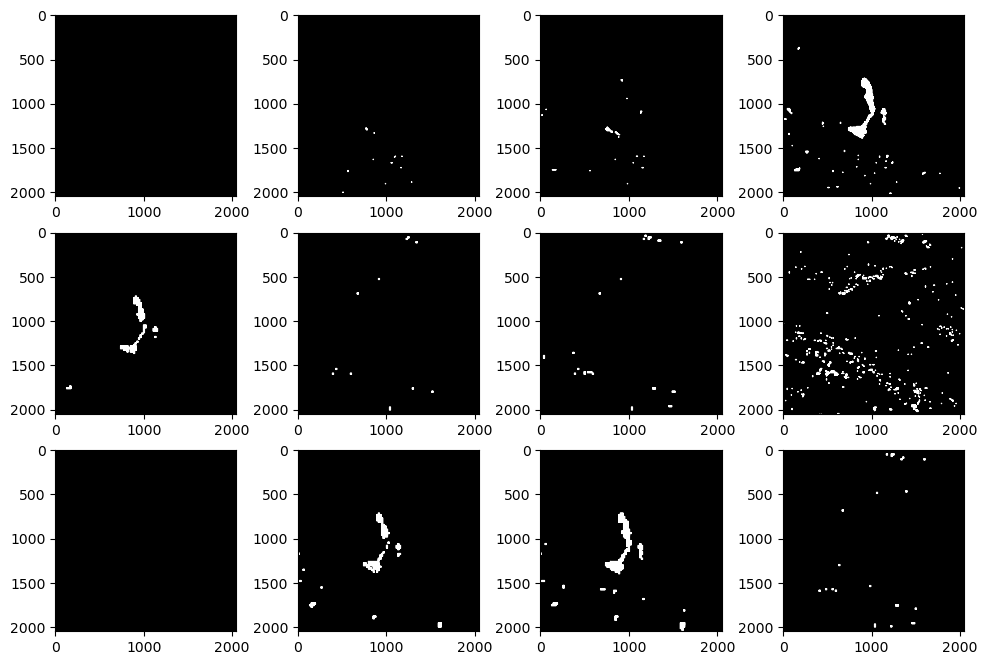

In [39]:
i = 41
th_B01_2 = Image.open("DATA/thresholds_005/threshold_B01/"+str(i)+".png")
th_B02_2 = Image.open("DATA/thresholds_005/threshold_B02/"+str(i)+".png")
th_B03_2 = Image.open("DATA/thresholds_005/threshold_B03/"+str(i)+".png")
th_B04_2 = Image.open("DATA/thresholds_005/threshold_B04/"+str(i)+".png")
th_B05_2 = Image.open("DATA/thresholds_005/threshold_B05/"+str(i)+".png")
th_B06_2 = Image.open("DATA/thresholds_005/threshold_B06/"+str(i)+".png")
th_B07_2 = Image.open("DATA/thresholds_005/threshold_B07/"+str(i)+".png")
th_B08_2 = Image.open("DATA/thresholds_005/threshold_B08/"+str(i)+".png")
th_B09_2 = Image.open("DATA/thresholds_005/threshold_B09/"+str(i)+".png")
th_B11_2 = Image.open("DATA/thresholds_005/threshold_B11/"+str(i)+".png")
th_B12_2 = Image.open("DATA/thresholds_005/threshold_B12/"+str(i)+".png")
th_B8A_2 = Image.open("DATA/thresholds_005/threshold_B8A/"+str(i)+".png")

f, axarr = plt.subplots(3,4)
axarr[0][0].imshow(th_B01_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(th_B02_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(th_B03_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(th_B04_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(th_B05_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(th_B06_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(th_B07_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(th_B08_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][0].imshow(th_B09_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][1].imshow(th_B11_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][2].imshow(th_B12_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][3].imshow(th_B8A_2, vmin=0, vmax=0.2, cmap='Greys_r')

### saving the CM to .tif [do not run]

In [ ]:
for i in range(len(landslide_df_3)):
    pre1_event_image = landslide_df_3.iloc[i].pre1.B04[0]
    pre2_event_image = landslide_df_3.iloc[i].pre2.B04[0]
    post_event_image = landslide_df_3.iloc[i].post.B04[0]
    
    change_map_no_landslide = pre2_event_image - pre1_event_image
    change_map_landslide = post_event_image - pre2_event_image
    threshold = 0.1  # Example threshold value
    binary_change_map_nl = (change_map_no_landslide > threshold).astype(int)
    binary_change_map_l = (change_map_landslide > threshold).astype(int)
    
    path_nl = "DATA/threshold_nl_CM/"+ str(i) + ".tif"
    path_l = "DATA/threshold_l_CM/"+ str(i) + ".tif"
    binary_change_map_nl.rio.to_raster(path_nl)
    binary_change_map_l.rio.to_raster(path_l)

### loading and visualizing the ground truth next to the change map geerated by differential threshold analysis

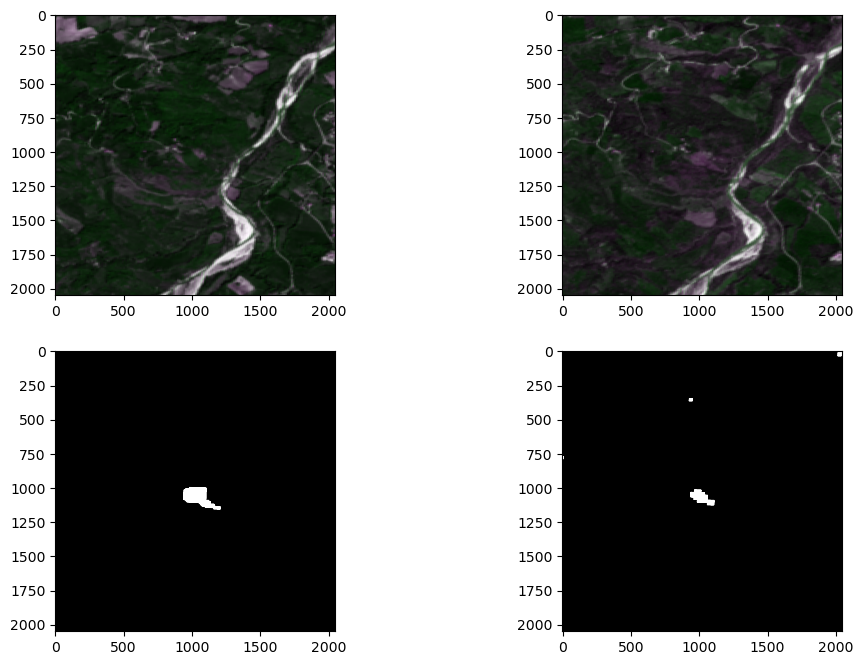

In [105]:
i = 61
GT = tiff.imread("DATA/GT/GT_" + str(i) + ".tif")
CM_pred = Image.open("DATA/thresholds/threshold_B12/" + str(i) + ".png")
im_post = Image.open("DATA/PNG/" + str(i) + "_post.png")
im_pre = Image.open("DATA/PNG/" + str(i) + "_pre2.png")

f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(im_pre, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(im_post, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(GT, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(CM_pred, vmin=0, vmax=0.2, cmap='Greys_r')

---

## mIoU function definition and calculation for the annotated images 

In [10]:
def calculate_miou_and_F1(y_true, y_pred):
    """
    Calculate mean Intersection over Union (mIoU) for binary classification.

    Parameters:
    - y_true: Ground truth binary mask (2D numpy array).
    - y_pred: Predicted binary mask (2D numpy array).

    Returns:
    - mIoU: Mean Intersection over Union.
    """

    FP = len(np.where(y_pred - y_true  == 1)[0])
    if type(y_true[0][0]) == np.float32:
        FN = len(np.where(y_pred - y_true  == -1)[0])
    else:
        FN = len(np.where(y_pred - y_true  == 255)[0])
    TP = len(np.where(y_pred + y_true == 2)[0])
    TN = len(np.where(y_pred + y_true == 0)[0])
    
    IoU_landslide = TP/(TP+FP+FN)
    IoU_no_landslide = TN/(TN+FP+FN)
    
    F1_l = TP/(TP+0.5*(FP+FN))   #---> for class "change"
    F1_nl = TN/(TN+0.5*(FP+FN))  #---> for class "no change"
    
    n_l = len(np.where(y_true == 1)[0])
    n_nl = len(np.where(y_true == 0)[0])
    
    F1 = (n_l * F1_l + n_nl * F1_nl)/(n_l+n_nl)        #---> weighted average of the two classes
    #F1 = TP/(TP+0.5*(FP+FN)) #<-- just for the change class
    
    mIoU = (IoU_landslide+IoU_no_landslide) / 2 # CLASS IMBALANCE!! CONSIDER WEIGHTED IF YOU WANT TO GIVE MORE IMPORTANCE TO THE MAJORITY CLASS 
    return mIoU, F1

### calculation for the differential thresholding analysis

**FOR B04 only:**

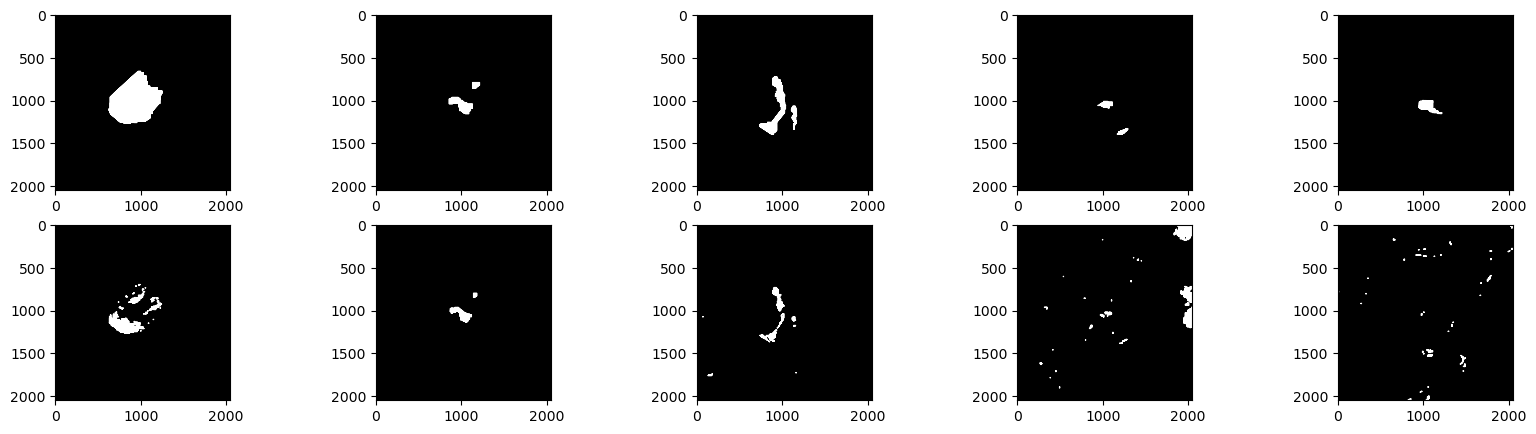

In [19]:
gt2 = tiff.imread("DATA/GT/GT_2.tif")
gt36 = tiff.imread("DATA/GT/GT_36.tif")
gt41 = tiff.imread("DATA/GT/GT_41.tif")
gt42 = tiff.imread("DATA/GT/GT_42.tif")
gt61 = tiff.imread("DATA/GT/GT_61.tif")
th2 = tiff.imread("DATA/threshold_l_CM/2.tif")
th36 = tiff.imread("DATA/threshold_l_CM/36.tif")
th41 = tiff.imread("DATA/threshold_l_CM/41.tif")
th42 = tiff.imread("DATA/threshold_l_CM/42.tif")
th61 = tiff.imread("DATA/threshold_l_CM/61.tif")

f, axarr = plt.subplots(2,5)
axarr[0][0].imshow(gt2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(gt36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(gt41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(gt42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][4].imshow(gt61, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(th2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(th36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(th41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(th42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][4].imshow(th61, vmin=0, vmax=0.2, cmap='Greys_r')

In [13]:
path = os.listdir('DATA/GT')
miou_list = []
F1_list = []

for event in path:
    if event[0] == 'G':
        path_gt = 'DATA/GT/' + event
        path_cm = 'DATA/threshold_l_CM/' + event[3:]
        
        GT = tiff.imread(path_gt)
        CM_pred = tiff.imread(path_cm)
        
        miou, F1 = calculate_miou_and_F1(GT, CM_pred)
        miou_list.append(miou)
        F1_list.append(F1)

average_mIoU = round(sum(miou_list)/len(miou_list)*100, 2)
print(f"the average mIoU for the differential threshold analysis was: {average_mIoU}%")

average_F1 = round(sum(F1_list)/len(F1_list)*100, 2)
print(f"the average F1 for the differential threshold analysis was: {average_F1}%")

the average mIoU for the differential threshold analysis was: 59.96%
the average F1 for the differential threshold analysis was: 97.96%


**FOR EACH BAND:**

In [20]:
path = os.listdir('DATA/thresholds/')

for band in path:
    band_path = os.listdir('DATA/thresholds/'+band)
    miou_list = []
    F1_list = []
    for img in band_path:
        if img[-1] == 'g':
            path_gt = 'DATA/GT_PNG/GT_' + img
            path_cm = 'DATA/thresholds/' + band + '/' + img

            GT = np.asarray(Image.open(path_gt))
            CM_pred = np.asarray(Image.open(path_cm))

            miou, F1 = calculate_miou_and_F1(GT, CM_pred)
            miou_list.append(miou)
            F1_list.append(F1)
    if len(miou_list) != 0:
        average_mIoU = round(sum(miou_list)/len(miou_list)*100, 2)
        print(f"mIoU of {band[-3:]} = {average_mIoU}%")

        average_F1 = round(sum(F1_list)/len(F1_list)*100, 2)
        print(f"F1 of {band[-3:]} = {average_F1}%")
        print("----------------")

mIoU of B11 = 11.79%
F1 of B11 = 19.06%
----------------
mIoU of B02 = 3.18%
F1 of B02 = 5.76%
----------------
mIoU of B06 = 1.49%
F1 of B06 = 2.58%
----------------
mIoU of B04 = 21.56%
F1 of B04 = 31.32%
----------------
mIoU of B08 = 1.41%
F1 of B08 = 2.45%
----------------
mIoU of B12 = 23.21%
F1 of B12 = 34.48%
----------------
mIoU of B03 = 6.01%
F1 of B03 = 10.1%
----------------
mIoU of B07 = 1.4%
F1 of B07 = 2.42%
----------------
mIoU of B05 = 8.09%
F1 of B05 = 13.44%
----------------
mIoU of B8A = 1.32%
F1 of B8A = 2.26%
----------------
mIoU of B09 = 0.47%
F1 of B09 = 0.88%
----------------
mIoU of B01 = 0.0%
F1 of B01 = 0.0%
----------------


### calculation for the BIT_CD analysis

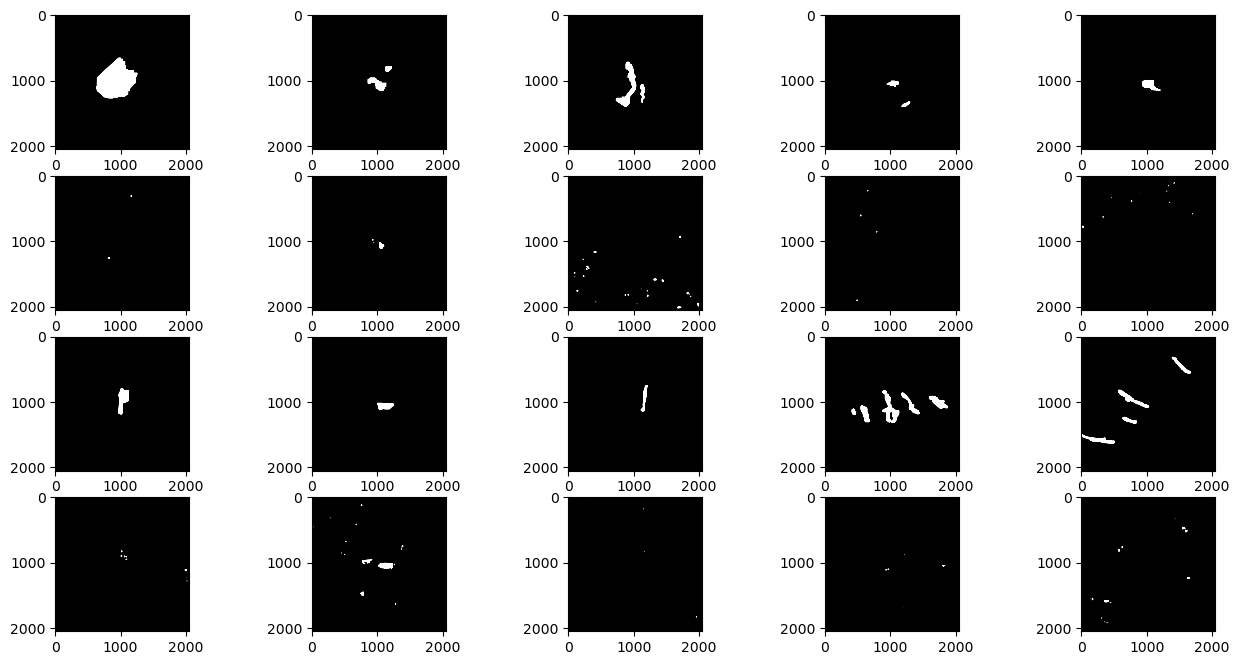

In [5]:
gt2 = Image.open("DATA/GT_PNG/GT_2.png")
gt36 = Image.open("DATA/GT_PNG/GT_36.png")
gt41 = Image.open("DATA/GT_PNG/GT_41.png")
gt42 = Image.open("DATA/GT_PNG/GT_42.png")
gt61 = Image.open("DATA/GT_PNG/GT_61.png")
gt75 = Image.open("DATA/GT_PNG/GT_75.png")
gt108 = Image.open("DATA/GT_PNG/GT_108.png")
gt121= Image.open("DATA/GT_PNG/GT_121.png")
gt125 = Image.open("DATA/GT_PNG/GT_125.png")
gt128 = Image.open("DATA/GT_PNG/GT_128.png")

bit2 = Image.open("DATA/BIT_CD_PRED/2.png")
bit36 = Image.open("DATA/BIT_CD_PRED/36.png")
bit41 = Image.open("DATA/BIT_CD_PRED/41.png")
bit42 = Image.open("DATA/BIT_CD_PRED/42.png")
bit61 = Image.open("DATA/BIT_CD_PRED/61.png")
bit75 = Image.open("DATA/BIT_CD_PRED/75.png")
bit108 = Image.open("DATA/BIT_CD_PRED/108.png")
bit121 = Image.open("DATA/BIT_CD_PRED/121.png")
bit125 = Image.open("DATA/BIT_CD_PRED/125.png")
bit128 = Image.open("DATA/BIT_CD_PRED/128.png")

f, axarr = plt.subplots(4,5)
axarr[0][0].imshow(gt2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(gt36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(gt41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(gt42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][4].imshow(gt61, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(bit2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(bit36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(bit41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(bit42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][4].imshow(bit61, vmin=0, vmax=0.2, cmap='Greys_r')

axarr[2][0].imshow(gt75, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][1].imshow(gt108, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][2].imshow(gt121, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][3].imshow(gt125, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][4].imshow(gt128, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[3][0].imshow(bit75, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[3][1].imshow(bit108, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[3][2].imshow(bit121, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[3][3].imshow(bit125, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[3][4].imshow(bit128, vmin=0, vmax=0.2, cmap='Greys_r')

In [14]:
path_png = os.listdir('DATA/GT_PNG')
miou_list_dl = []
F1_list_dl = []

for event in path_png:
    if event[0] == 'G':
        path_gt = 'DATA/GT_PNG/' + event
        path_cm = 'DATA/BIT_CD_PRED/' + event[3:]
        
        GT_png = np.asarray(Image.open(path_gt))
        BIT_CD_PRED = np.asarray(Image.open(path_cm))
        
        miou_dl, F1_dl = calculate_miou_and_F1(GT_png, BIT_CD_PRED)
        miou_list_dl.append(miou_dl)
        F1_list_dl.append(F1_dl)

average_mIoU_dl = round(sum(miou_list_dl)/len(miou_list_dl)*100, 2)
print(f"the average mIoU for the DL analysis was: {average_mIoU_dl}%")

average_F1_dl = round(sum(F1_list_dl)/len(F1_list_dl)*100, 2)
print(f"the average F1 for the DL analysis was: {average_F1_dl}%")

the average mIoU for the DL analysis was: 52.0%
the average F1 for the DL analysis was: 97.25%


### calculation for the CDRL

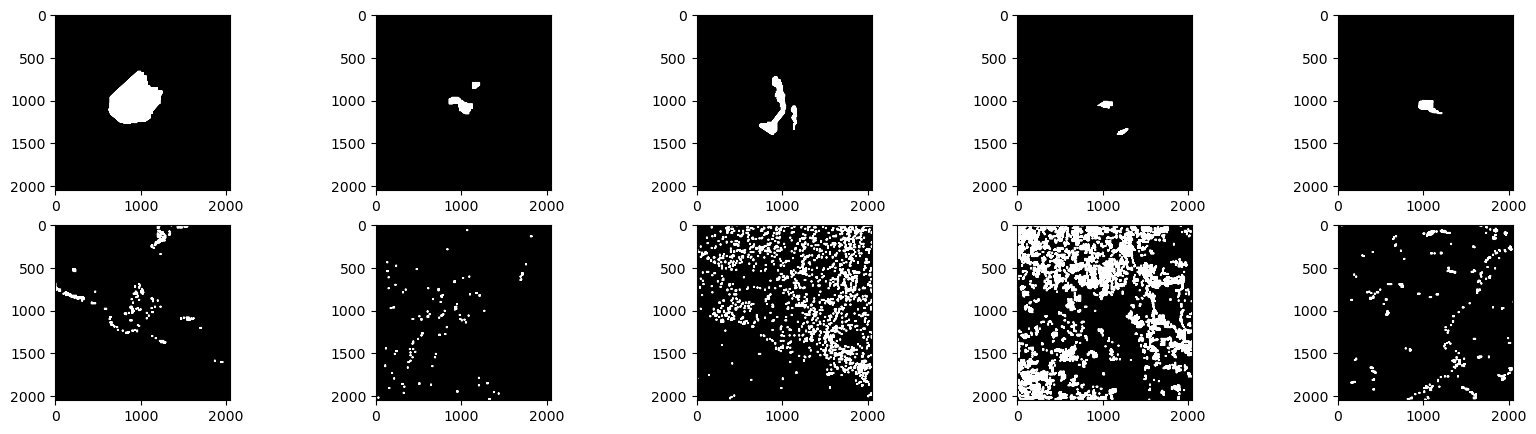

In [15]:
gt2 = Image.open("DATA/GT_PNG/GT_2.png")
gt36 = Image.open("DATA/GT_PNG/GT_36.png")
gt41 = Image.open("DATA/GT_PNG/GT_41.png")
gt42 = Image.open("DATA/GT_PNG/GT_42.png")
gt61 = Image.open("DATA/GT_PNG/GT_61.png")
cdrl2 = Image.open("DATA/CDRL_th_075_binary/2.png")
cdrl36 = Image.open("DATA/CDRL_th_075_binary/36.png")
cdrl41 = Image.open("DATA/CDRL_th_075_binary/41.png")
cdrl42 = Image.open("DATA/CDRL_th_075_binary/42.png")
cdrl61 = Image.open("DATA/CDRL_th_075_binary/61.png")

f, axarr = plt.subplots(2,5)
axarr[0][0].imshow(gt2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(gt36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(gt41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(gt42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][4].imshow(gt61, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(cdrl2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(cdrl36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(cdrl41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(cdrl42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][4].imshow(cdrl61, vmin=0, vmax=0.2, cmap='Greys_r')

In [29]:
miou_CDRL = []
F1_CDRL = []
path = os.listdir('DATA/CDRL_th_075_binary')
for img in path:
    if img[-1] == 'g':
        path_GT = "DATA/GT_PNG/GT_"+img
        path_CDRL = "DATA/CDRL_th_075_binary/"+img

        GT = Image.open(path_GT)
        CDRL = Image.open(path_CDRL)

        miou, F1 = calculate_miou_and_F1(np.asarray(GT), np.asarray(CDRL))
        miou_CDRL.append(miou)
        F1_CDRL.append(F1)

average_mIoU_CDRL = round(sum(miou_CDRL)/len(miou_CDRL)*100, 2)
print(f"the average mIoU for the DL analysis was: {average_mIoU_CDRL}%")

average_F1_CDRL = round(sum(F1_CDRL)/len(F1_CDRL)*100, 2)
print(f"the average F1 for the DL analysis was: {average_F1_CDRL}%")

the average mIoU for the DL analysis was: 47.66%
the average F1 for the DL analysis was: 5.73%


### calculation for the CDRL-SA

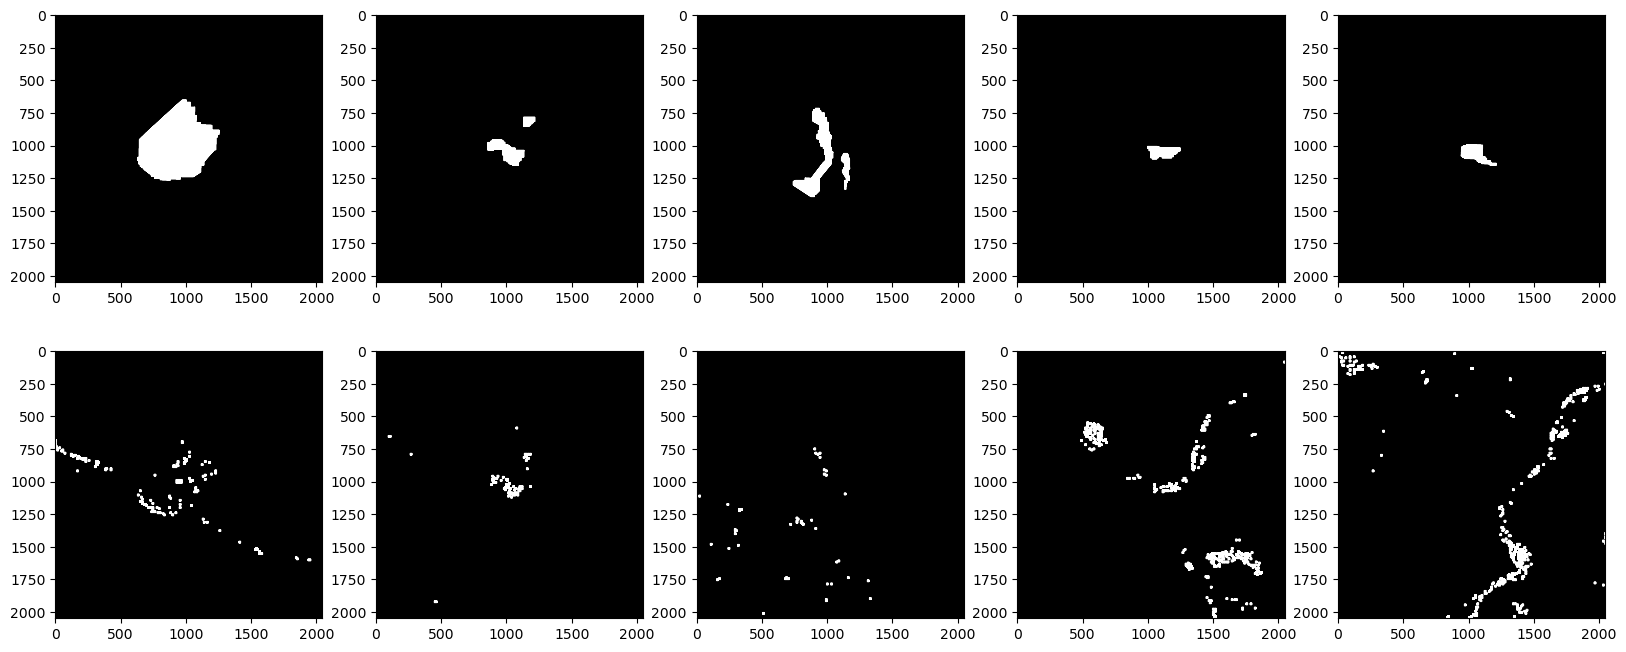

In [8]:
gt2 = Image.open("DATA/GT_PNG/GT_2.png")
gt36 = Image.open("DATA/GT_PNG/GT_36.png")
gt41 = Image.open("DATA/GT_PNG/GT_41.png")
gt42 = Image.open("DATA/GT_PNG/GT_108.png")
gt61 = Image.open("DATA/GT_PNG/GT_61.png")
cdrlsa2 = Image.open("DATA/CDRL-SA_binary/2.png")
cdrlsa36 = Image.open("DATA/CDRL-SA_binary/36.png")
cdrlsa41 = Image.open("DATA/CDRL-SA_binary/41.png")
cdrlsa42 = Image.open("DATA/CDRL-SA_binary/108.png")
cdrlsa61 = Image.open("DATA/CDRL-SA_binary/61.png")

f, axarr = plt.subplots(2,5)
axarr[0][0].imshow(gt2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(gt36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(gt41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(gt42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][4].imshow(gt61, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(cdrlsa2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(cdrlsa36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(cdrlsa41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(cdrlsa42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][4].imshow(cdrlsa61, vmin=0, vmax=0.2, cmap='Greys_r')

In [12]:
miou_CDRL_SA = []
F1_CDRL_SA = []
path = os.listdir('DATA/CDRL-SA_binary')
for img in path:
    if img[-1] == 'g':
        path_GT = "DATA/GT_PNG/GT_"+img
        path_CDRL_SA = "DATA/CDRL-SA_binary/"+img
    
        GT = Image.open(path_GT)
        CDRL_SA = Image.open(path_CDRL_SA)
    
        miou, F1 = calculate_miou_and_F1(np.asarray(GT), np.asarray(CDRL_SA))
        miou_CDRL_SA.append(miou)
        F1_CDRL_SA.append(F1)

average_mIoU_CDRL_SA = round(sum(miou_CDRL_SA)/len(miou_CDRL_SA)*100, 2)
print(f"the average mIoU for the CDRL-SA DL analysis was: {average_mIoU_CDRL_SA}%")

average_F1_CDRL_SA = round(sum(F1_CDRL_SA)/len(F1_CDRL_SA)*100, 2)
print(f"the average F1 for the CDRL-SA DL analysis was: {average_F1_CDRL_SA}%")

the average mIoU for the CDRL-SA DL analysis was: 52.34%
the average F1 for the CDRL-SA DL analysis was: 97.08%


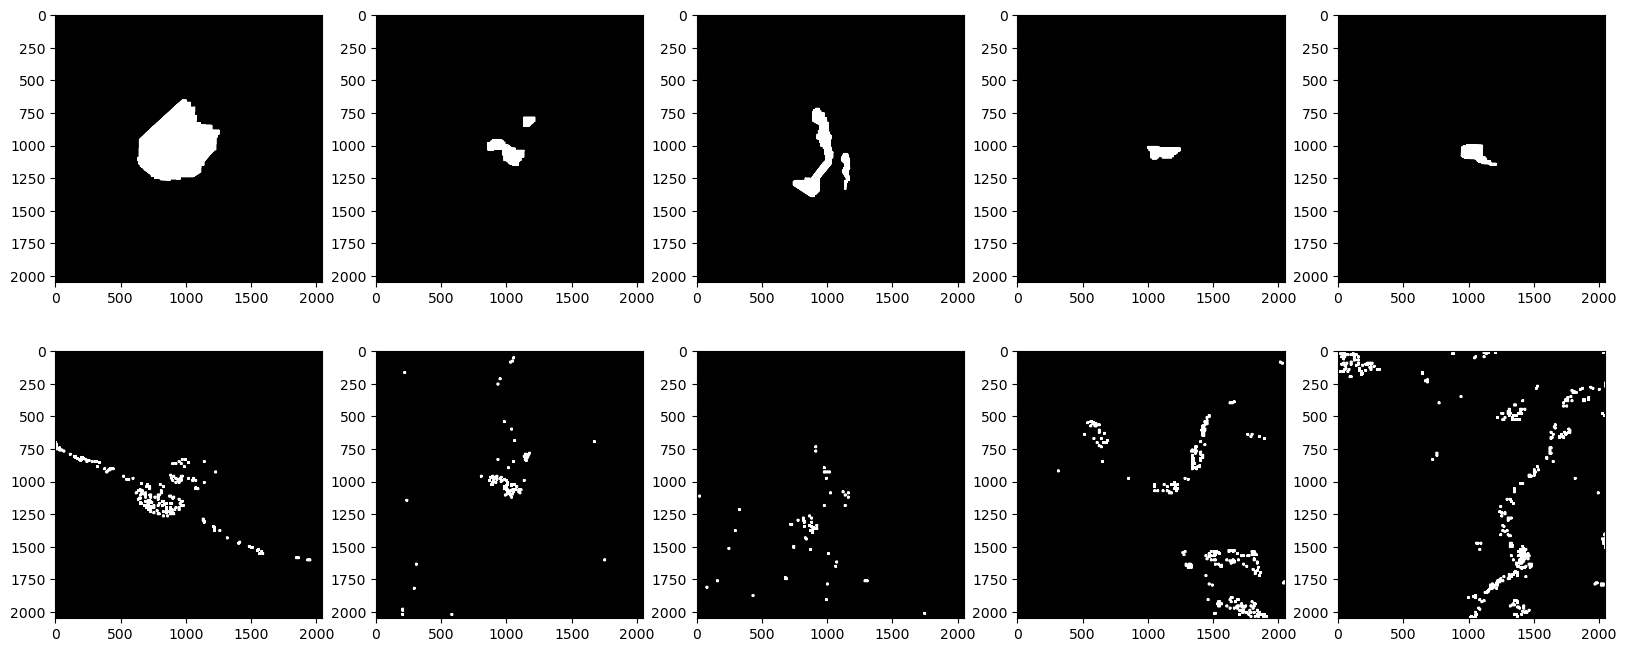

In [7]:
gt2 = Image.open("DATA/GT_PNG/GT_2.png")
gt36 = Image.open("DATA/GT_PNG/GT_36.png")
gt41 = Image.open("DATA/GT_PNG/GT_41.png")
gt42 = Image.open("DATA/GT_PNG/GT_108.png")
gt61 = Image.open("DATA/GT_PNG/GT_61.png")
cdrlsa2 = Image.open("DATA/CDRL-SA-new_binary/2.png")
cdrlsa36 = Image.open("DATA/CDRL-SA-new_binary/36.png")
cdrlsa41 = Image.open("DATA/CDRL-SA-new_binary/41.png")
cdrlsa42 = Image.open("DATA/CDRL-SA-new_binary/108.png")
cdrlsa61 = Image.open("DATA/CDRL-SA-new_binary/61.png")

f, axarr = plt.subplots(2,5)
axarr[0][0].imshow(gt2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].imshow(gt36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].imshow(gt41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].imshow(gt42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][4].imshow(gt61, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].imshow(cdrlsa2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].imshow(cdrlsa36, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].imshow(cdrlsa41, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].imshow(cdrlsa42, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][4].imshow(cdrlsa61, vmin=0, vmax=0.2, cmap='Greys_r')

In [11]:
miou_CDRL_SA = []
F1_CDRL_SA = []
path = os.listdir('DATA/CDRL-SA-new_binary')
for img in path:
    if img[-1] == 'g':
        path_GT = "DATA/GT_PNG/GT_"+img
        path_CDRL_SA = "DATA/CDRL-SA-new_binary/"+img
    
        GT = Image.open(path_GT)
        CDRL_SA = Image.open(path_CDRL_SA)
    
        miou, F1 = calculate_miou_and_F1(np.asarray(GT), np.asarray(CDRL_SA))
        miou_CDRL_SA.append(miou)
        F1_CDRL_SA.append(F1)

average_mIoU_CDRL_SA = round(sum(miou_CDRL_SA)/len(miou_CDRL_SA)*100, 2)
print(f"the average mIoU for the CDRL-SA DL analysis (with more epochs) was: {average_mIoU_CDRL_SA}%")

average_F1_CDRL_SA = round(sum(F1_CDRL_SA)/len(F1_CDRL_SA)*100, 2)
print(f"the average F1 for the CDRL-SA DL analysis (with more epochs) was: {average_F1_CDRL_SA}%")

the average mIoU for the CDRL-SA DL analysis (with more epochs) was: 52.95%
the average F1 for the CDRL-SA DL analysis (with more epochs) was: 97.16%


In [15]:
miou_CDRL_n = []
F1_CDRL_n = []
path = os.listdir('DATA/CDRL_newPNGs')
for img in path:
    if img[-1] == 'g':
        path_GT = "DATA/GT_PNG/GT_"+img
        path_CDRL = "DATA/CDRL_newPNGs/"+img

        GT = Image.open(path_GT)
        CDRL = Image.open(path_CDRL)

        miou, F1 = calculate_miou_and_F1(np.asarray(GT), np.asarray(CDRL))
        miou_CDRL_n.append(miou)
        F1_CDRL_n.append(F1)

average_mIoU_CDRL_n = round(sum(miou_CDRL_n)/len(miou_CDRL_n)*100, 2)
print(f"the average mIoU for the DL analysis was: {average_mIoU_CDRL_n}%")

average_F1_CDRL_n = round(sum(F1_CDRL_n)/len(F1_CDRL_n)*100, 2)
print(f"the average F1 for the DL analysis was: {average_F1_CDRL_n}%")

the average mIoU for the DL analysis was: 44.35%
the average F1 for the DL analysis was: 89.64%


### saving the GT annotations also as .png and transforming DL preds in range [0, 1] [do not run]

In [119]:
path = os.listdir('DATA/GT')
for event in path:
    if event[0] == 'G':
        path_out = 'DATA/GT_PNG/' + event[:-4] + '.png'
        path_in = 'DATA/GT/' + event
        image = tiff.imread(path_in)
        #image = image[:,:,:3]
        im = Image.fromarray((image).astype(np.uint8))
        im.save(path_out)

___

### TIFFFILE NOT WORKING ON THIS SERVER IDK WHY


In [41]:
path = os.listdir('DATA/GeoTIFF')
for event in path:
    imgs = os.listdir('DATA/GeoTIFF' + '/' + event)
    for img_in in imgs:
        if img_in[0] =='p':
            path_out = 'DATA/PNG/' + event + '_' + img_in[:4] + '.png'
            path_in = 'DATA/GeoTIFF/' + event + '/' + img_in
            image = tiff.imread(path_in)
            image = image[:,:,:3]
            
            for i in range(3):
                image[:,:,i] = (image[:,:,i] - min(image[:,:,i].flatten()))/(max(image[:,:,i].flatten()) - min(image[:,:,i].flatten()))
                
            im = Image.fromarray((image*255).astype(np.uint8))
            im.save(path_out)            

ValueError: failed to read 83886080 bytes, got 10467824

In [40]:
522/3

174.0

## I'm working on the deep learning inference of CM on Google Colab

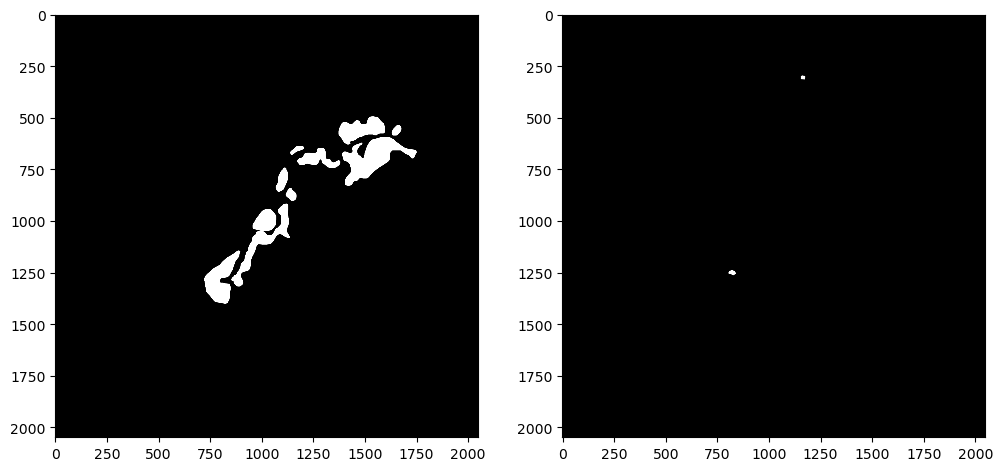

In [335]:
GT_dl = Image.open("DATA/GT_PNG/GT_173.png")
CM_pred_dl = Image.open("DATA/BIT_CD_PRED/2.png")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(GT_dl, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(CM_pred_dl, vmin=0, vmax=0.2, cmap='Greys_r')

In [11]:
BBOXs = {
    "2" : (625, 650, 1260, 1275),
    "36" : (850, 780, 1220, 1160),
    "41" : (730, 710, 1170, 1400),
    "42": (940, 1000, 1300, 1400),
    "61" : (937, 995, 1211, 1160),
    "75" : (970, 790, 1130, 1180),
    "108" : (995, 1005, 1250, 1110),
    "121" : (1110, 740, 1222, 1135),
    "125" : (400, 810, 1880, 1310),
    "128" : (0, 300, 1680, 1630),
    "135" : (967, 1038, 1033, 1185),
    "140" : (975, 955, 2048, 1160),
    "155" : (0, 850, 2048, 2048),
    "158" : (920, 1014, 1115, 1092),
    "164" : (60, 940, 2048, 2048),
    "171" : (910, 1005, 1417, 1410),
    "173" : (720, 490, 1750, 1410)
}

In [353]:
path = os.listdir('DATA/BIT_CD_PRED/')
for event in path:
    if event[-1] == 'g':
        print(BBOXs[event[:-4]])

(975, 955, 2048, 1160)
(730, 710, 1170, 1400)
(850, 780, 1220, 1160)
(995, 1005, 1250, 1110)
(967, 1038, 1033, 1185)
(910, 1005, 1417, 1410)
(937, 995, 1211, 1160)
(0, 300, 1680, 1630)
(60, 940, 2048, 2048)
(720, 490, 1750, 1410)
(0, 850, 2048, 2048)
(920, 1014, 1115, 1092)
(940, 1000, 1300, 1400)
(625, 650, 1260, 1275)
(400, 810, 1880, 1310)
(1110, 740, 1222, 1135)
(970, 790, 1130, 1180)


In [16]:
path = os.listdir('DATA/thresholds_005/')
for band in path:
    if band[0] == 't':
        band_path = os.listdir('DATA/thresholds_005/'+band)
        for img in band_path:
            if img[-1] == 'g':
                img_pred = Image.open('DATA/thresholds_005/'+band+"/"+img)

                bbox = BBOXs[img[:-4]]
                img_pred_crop = img_pred.crop(bbox)

                img_pred_crop.save('DATA/thresholds_005_cropped/'+band+"/"+img)

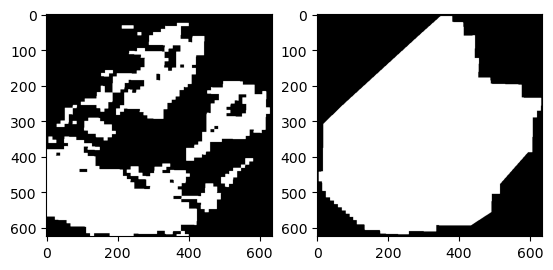

In [17]:
TH = Image.open('DATA/thresholds_005_cropped/threshold_B04/2.png')
GT = Image.open('DATA/GT_PNG_cropped/2.png')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(TH, cmap='Greys_r')
axarr[1].imshow(GT, cmap='Greys_r')

In [356]:
path = os.listdir('DATA/BIT_CD_PRED/')
for event in path:
    if event[-1] == 'g':
        img_pred = Image.open('DATA/BIT_CD_PRED/'+event)
        img_gt = Image.open('DATA/GT_PNG/GT_'+event)
        
        bbox = BBOXs[event[:-4]]
        img_pred_crop = img_pred.crop(bbox)
        img_gt_crop = img_gt.crop(bbox)
        
        img_pred_crop.save('DATA/BIT_cropped/'+event)
        img_gt_crop.save('DATA/GT_PNG_cropped/'+event)

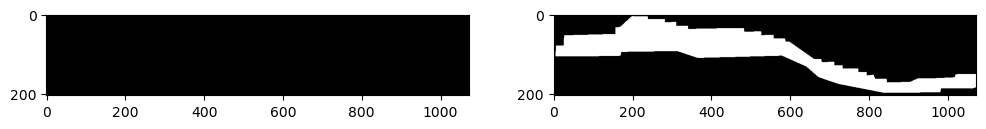

In [24]:
BIT = Image.open('DATA/BIT_cropped/140.png')
GT = Image.open('DATA/GT_PNG_cropped/140.png')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(BIT, cmap='Greys_r')
axarr[1].imshow(GT, cmap='Greys_r')

In [28]:
#DATAFRANME WITH id, size of image, compactness, ommission, commission, miou, F1
#sum(np.asarray(GT).flatten())/len(np.asarray(GT).flatten())

BIT_list = []
for key in BBOXs:
    BIT = np.asarray(Image.open('DATA/BIT_cropped/'+key+'.png'))
    GT = np.asarray(Image.open('DATA/GT_PNG_cropped/'+key+'.png'))
    
    size = round(sum(GT.flatten())*100/1000000,2)
    miou, F1 = calculate_miou_and_F1(GT, BIT)
    miou = round(miou*100,2)
    F1 = round(F1*100,2)
    BIT_list.append(
        {
            'id':key,
            'size': size, 
            #'compactness_index': ,
            #'ommission_error': ,
            #'commission_error': ,
            'mIoU': miou,
            'F1': F1
        }
    )

In [29]:
BIT_df = pd.DataFrame(BIT_list)
BIT_df

,is,size,mIoU,F1
0,2,24.56,19.16,21.26
1,36,3.19,46.30,73.76
2,41,6.98,38.50,67.01
3,42,1.29,45.51,86.75
4,61,2.14,26.29,36.23
5,75,3.52,23.13,29.05
6,108,1.76,61.85,77.61
7,121,1.38,34.50,56.22
8,125,11.25,42.71,78.03
9,128,7.08,50.72,95.60


### CDRL: import results, resize, transform, calculate metrics

In [13]:
path = os.listdir('DATA/CDRL_newPNGs')
for event in path:
    if event[-1] == 'g':
        #print(event)
        #path_out = 'DATA/CDRL_th_075_binary/' + event[:-4] + '.png'
        path_in = 'DATA/CDRL_newPNGs/' + event
        image = Image.open(path_in)
        image_resize = image.resize((2048, 2048))
        binary_image = np.any(np.asarray(image_resize) > 0, axis=2).astype(np.uint8)
        binary_image = Image.fromarray(binary_image)
        binary_image.save(path_in)

### CDRL-SA: import results, resize, transform, calculate metrics 

In [10]:
path = os.listdir('DATA/CDRL_SA_27')
for event in path:
    if event[-1] == 'g':
        path_out = 'DATA/CDRL_SA_27_binary/' + event[:-4] + '.png'
        path_in = 'DATA/CDRL_SA_27/' + event
        image = Image.open(path_in)
        image_resize = image.resize((2048, 2048))
        binary_image = np.any(np.asarray(image_resize) > 0, axis=2).astype(np.uint8)
        binary_image = Image.fromarray(binary_image)
        binary_image.save(path_out)

## TODO: 
    * the thresholds need to be in .png
    * create also the GT for no landslide and see how the changes compare (?)
    * think about what's next after the inference in DL
    * png images - should be of better quality
    * OutOfMemoryError handling